### Analysis of real data - calculating differencing over whole sample
    * data has 4 channels from the heterodyning ( frequency mixing), time stamps are slightly different for each channel - large files so don’t read in whole thing (try 10,000 points) - the frequencies are important so the whole time series is not required
  
    
Data is on USB - the 3 files with roman/arabic numerals are consecutive.
Begin with the run-43 file
-read in data
-remove header lines 
run-43 has 28929007 lines and the first 7 are info: 28929000 lines of data in 4 columns 

In [145]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal


def difference_chunk(first_data_line, total_data_line, no_bins):
    #input: define the boundaries of the input data to call and the number of bins
    #body: runs spectrogram and differences data 
    #output: the counts array of differenced pixels, n


    #read in n lines of data         X0   Y0   X1   Y1

    #the data is the signal in Volts, but the callibration is not clear yet so take as arbitrary units
    #skips the first 7 rows and places the next 4000000 in a numpy array

    data43 = np.loadtxt(fname = 'dataFiles/run-43', skiprows = first_data_line +7, max_rows = total_data_line)


    X0 = data43[:,0]
    Y0 = data43[:,1]
    iY0 = 1j*Y0
    #combine x+iy to make complex signal
    sig_0 = X0+iY0

    
    #time step (seconds)
    dt = 0.01
    
    #SPECTROGRAM
    spectrum, freqs, t_bins, im = plt.specgram(x=sig_0, Fs=1/dt, NFFT = 2000)
    #suppress plot
    plt.clf()
    
    #Median normalisation across individual frequencies
    norm_spectrum = np.ones(np.shape(spectrum))
    for row in range(len(spectrum)):
        median_row =  np.median(spectrum[row])
        norm_spectrum[row] = spectrum[row]/median_row

    
    #Frequency slicing
    #need to take frequencies in the resonant mode roughly 2-4Hz and one ouside this range eg. 30-40Hz

    def freq_slice(min_freq, max_freq, freqs, t_bins, norm_spectrum):
        '''function slices the array containing the frequency spectrum using the min and max boundaries,
        and the corresponding spectrum powers. It plots the slices specgram and returns slice spectrum.'''

        #find the elements in the array in the HZ range
        slice_freqs = freqs[(min_freq<freqs) & (freqs<max_freq)]
        #and their indicies
        slice_indices = np.where((min_freq<freqs) & (freqs<max_freq))

        #need the spectrum powers corresponding to these freqs
        slice_spectrum = norm_spectrum[slice_indices]
        
        return slice_spectrum
    
    res_slice_spec = freq_slice(-3,-2, freqs=freqs, t_bins=t_bins, norm_spectrum=norm_spectrum)

    bkgd_slice_spec = freq_slice(20,30, freqs=freqs, t_bins=t_bins, norm_spectrum=norm_spectrum)


    #array containing the differences between successive columns of spectrogram data in spectrum

    def difference(power_spectrum, spec_ydim, spec_xdim):
        
        #difference array will have one fewer column 
        diff_spec = np.ones((spec_ydim, spec_xdim -1))

        for i in range(spec_ydim):
            for j in range(spec_xdim-1):
                diff_spec[i,j] = power_spectrum[i,j+1] - power_spectrum[i,j]
                

        #(square differences) <- changed to absolute value
        diff_spec = np.absolute(diff_spec)

        return diff_spec

    #resonant mode slice:
    res_diff_spec = difference(res_slice_spec, np.shape(res_slice_spec)[0], np.shape(res_slice_spec)[1])
    bkgd_diff_spec = difference(bkgd_slice_spec,np.shape(bkgd_slice_spec)[0], np.shape(bkgd_slice_spec)[1])
    
    
    #slices histogram
    def slice_hist(diff_spec, title):


        #want to plot all pixels so flatten array to 1D
        diff_spec = np.array(diff_spec).flatten()

        #Histogram of logN vs diff(f,t) - (N counts)

        n, bins, patches = plt.hist(x=diff_spec, bins=no_bins, log = True)

        plt.clf()
        return n,bins

    #plot hists of both slices

    #1-resonant mode, undifferenced
     
    uRes = slice_hist(res_slice_spec, title = 'Undifferenced Spectrogram: 2-3Hz Resonant Mode')
     
    #2-resonant mode slice, differenced
    
    dRes = slice_hist(res_diff_spec, title = 'Differenced Spectrogram: 2-4Hz Resonant Mode')

    #3-background slice, undifferenced
    
    uBkg = slice_hist(bkgd_slice_spec, title = 'Undifferenced Spectrogram: Background')

    #4-background slice, differenced
    
    dBkg = slice_hist(bkgd_diff_spec, title = 'Differenced Spectrogram: Background')
    
    return  uRes, dRes, uBkg, dBkg


In [146]:
#First chunk of data - reading in 4M from line 0(+7) 
n1 = difference_chunk(0,4000000, no_bins=1000)
#when on auto binning, 73000 bins are used for this size of data - keep at 1000 for now 
#but change later for accuracy


<Figure size 432x288 with 0 Axes>

In [147]:
n2 = difference_chunk(4000000,4000000,no_bins=1000)

<Figure size 432x288 with 0 Axes>

In [148]:
n3 = difference_chunk(8000000,4000000,no_bins=1000)

<Figure size 432x288 with 0 Axes>

In [149]:
n4 = difference_chunk(12000000,4000000,no_bins=1000)

<Figure size 432x288 with 0 Axes>

In [150]:
n5 = difference_chunk(16000000,4000000,no_bins=1000)

<Figure size 432x288 with 0 Axes>

In [151]:
n6 = difference_chunk(20000000,4000000,no_bins=1000)

<Figure size 432x288 with 0 Axes>

In [152]:
n7 = difference_chunk(24000000,4000000,no_bins=1000)

<Figure size 432x288 with 0 Axes>

In [153]:
#combine histogram outputs
#at resonant mode:

tot_uRes = n1[0] + n2[0] + n3[0] + n4[0] + n5[0] + n6[0] + n7[0]
#at background(off resonant mode)
tot_dRes = n1[1] + n2[1] + n3[1] + n4[1] + n5[1] + n6[1] + n7[1]

tot_uBkg = n1[2] + n2[2] + n3[2] + n4[2] + n5[2] + n6[2] + n7[2]

tot_dBkg = n1[3] + n2[3] + n3[3] + n4[3] + n5[3] + n6[3] + n7[3]

Text(0.5, 1.0, 'Differenced Spectrogram: Background')

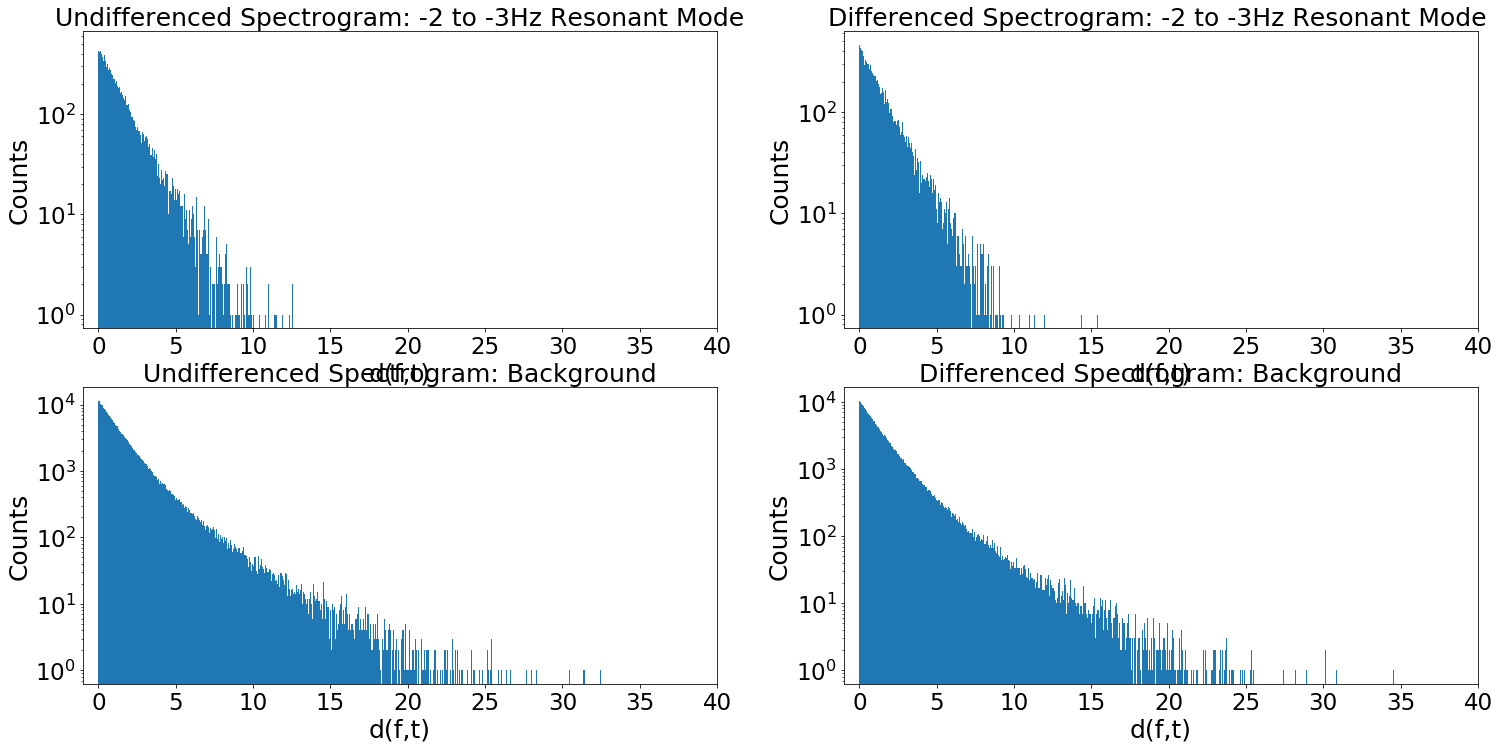

In [156]:
#plot histogram of combined hist counts for res and bkgr slices


def tot_hist(n_tot,tot_bins):
    counts = n_tot
    bins = tot_bins
    plt.xticks(fontsize=23)
    plt.yticks(fontsize=23)
    
    plt.hist(bins[:-1], bins, weights=counts, log = True)
    plt.xlabel('d(f,t)',fontsize=25)
    plt.ylabel('Counts',fontsize=25)
    plt.xlim(-1,40)


    return

plt.figure(figsize=(25,12))

plt.subplot(221)
tot_hist(tot_uRes[0],tot_bins=tot_uRes[1])
plt.title('Undifferenced Spectrogram: -2 to -3Hz Resonant Mode',fontsize=25)

plt.subplot(222)
tot_hist(tot_dRes[0],tot_bins=tot_dRes[1])
plt.title('Differenced Spectrogram: -2 to -3Hz Resonant Mode ',fontsize=25)

plt.subplot(223)
tot_hist(tot_uBkg[0],tot_bins=tot_uBkg[1])
plt.title('Undifferenced Spectrogram: Background',fontsize=25)

plt.subplot(224)
tot_hist(tot_dBkg[0],tot_bins=tot_dBkg[1])
plt.title('Differenced Spectrogram: Background',fontsize=25)

